In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# supress warning
pd.options.mode.chained_assignment = None

# load data

In [2]:
# importing data and reading data from csv file
# Values have spaces at the beginning --> remove them with skipinitialspace
data = pd.read_csv('data/adult.csv', header = None, skipinitialspace = True)
# set headers
data.columns = ['age', 'workclass', "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income" ]
# show dataset
data.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


# describe dataset

In [47]:
# description of the dataset
pd.set_option("max_colwidth", None)
desc = ['Describes the age of individuals.','Different types of employment (e.g. State-gov, Never-worked).','If two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. They are not standardized across different states.',
       'Different types of academic degrees (e.g. Bachelor).','Number of years spent in education.','The distinct options that describe a person´s relationship with a significant other (e.g. Married).',
        'A job or profession (e.g. Sales, Tech-support).','The way in which two or more people or groups regard and behave towards each other (e.g. Wife, Husband).','Race of the person (e.g. White, Black).','Gender of the person (Male or Female).','Is the profit one earns on the sale of an asset like stocks.',
        'Loss incurred when a capital asset (e.g. a stock) decreases in value.','The time a person works per week.','Country of origin.','Annual salary.']
data_details = pd.DataFrame(list(zip(data.columns, desc)), columns =['Column', 'Description'])
data_details

count    32537.000000
mean        38.585549
std         13.637984
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [4]:
# 32561 rows, 15 columns
data.shape

(32561, 15)

In [5]:
# Check for Null Data
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [6]:
# dataset has no NaNs but a lot of ?
data.select_dtypes(object).apply(lambda x: x.str.contains('?', regex=False)).sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

In [7]:
# Get data types
data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [8]:
# show all duplicated entries of the dataset
print('Duplicated entries:', data.duplicated().sum())

Duplicated entries: 24


## visualization

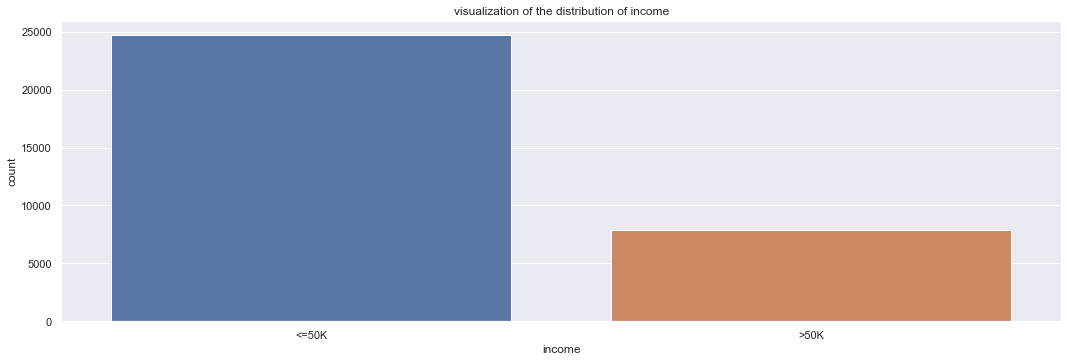

In [9]:
# visualization of the distribution of income
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,5))
sns.countplot(x="income", data=data)
plt.tight_layout()
plt.title('visualization of the distribution of income')
plt.show()

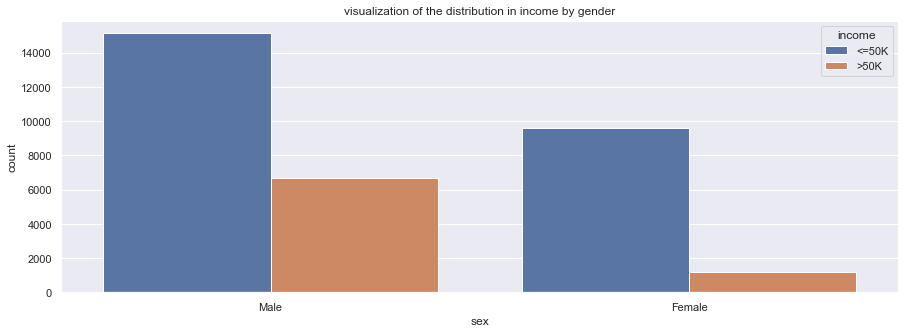

In [10]:
# visualization of the distribution in income by gender
plt.figure(figsize=(15,5))
sns.countplot(x="sex", hue='income', data=data)
plt.title('visualization of the distribution in income by gender')
plt.show()

In [11]:
#split age in different groups for visualization
data_age = []
def age_group(x):
    x = int(x)
    x = abs(x)
    if( 18 < x < 31 ):
        return "19-30"
    if( 30 < x < 41 ):
        return "31-40"
    if( 40 < x < 51 ):
        return "41-50"
    if( 50 < x < 61 ):
        return "51-60"
    if( 60 < x < 71 ):
        return "61-70"
    else:
        return "Greater than 70"

data_age = data['age'].apply(age_group)

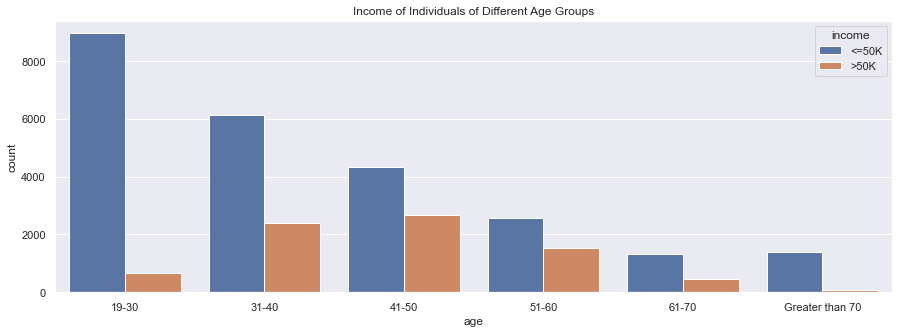

In [12]:
# visualization of the distribution in income by age group
plt.figure(figsize=(15,5))
order_list = ['19-30', '31-40', '41-50', '51-60', '61-70', 'Greater than 70']
sns.countplot(x = data_age, hue = data['income'], order = order_list, data=data)
plt.title('Income of Individuals of Different Age Groups')
plt.show()

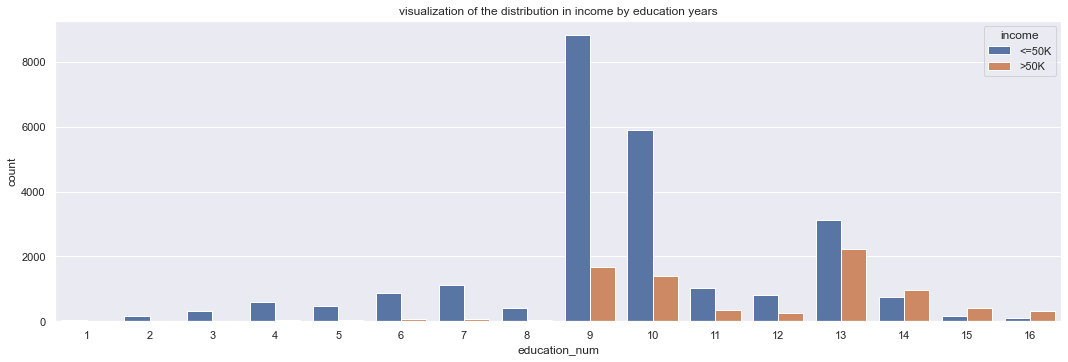

In [13]:
# visualization of the distribution in income by education years
plt.figure(figsize=(15,5))
sns.countplot(x = 'education_num', hue = 'income', data = data)
plt.tight_layout()
plt.title('visualization of the distribution in income by education years')
plt.show()

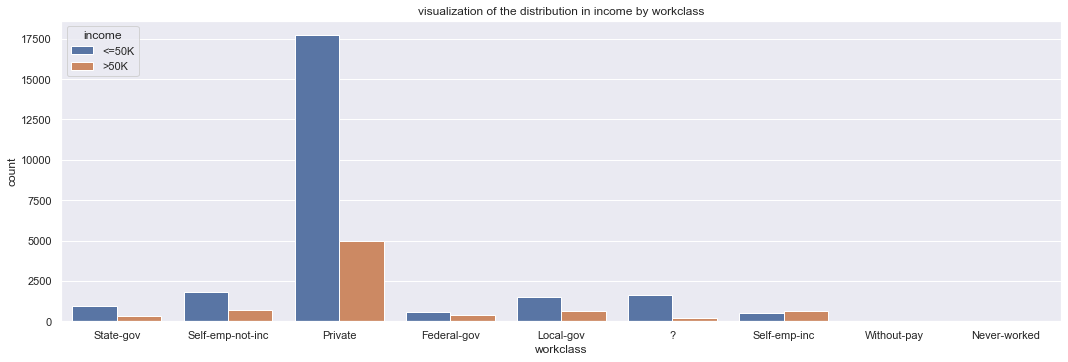

In [14]:
# visualization of the distribution in income by workclass
plt.figure(figsize=(15,5))
sns.countplot(x = 'workclass', hue = 'income', data = data)
plt.tight_layout()
plt.title('visualization of the distribution in income by workclass')
plt.show()

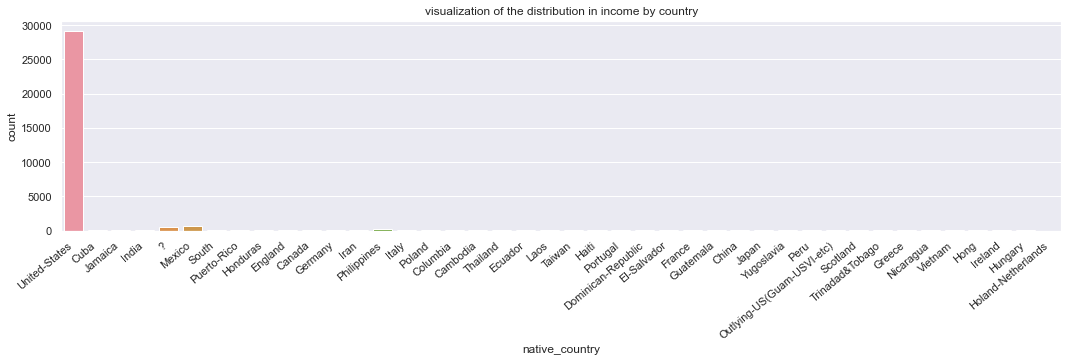

In [15]:
# visualization of the distribution in income by country
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'native_country', data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('visualization of the distribution in income by country')
plt.show()

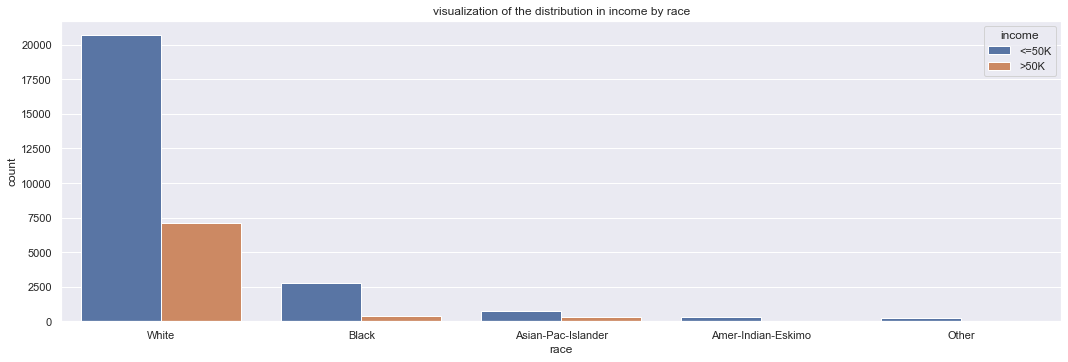

In [16]:
# visualization of the distribution in income by race
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'race', hue = 'income', data = data)
plt.tight_layout()
plt.title('visualization of the distribution in income by race')
plt.show()

# preprocess data

In [17]:
# replace ? with Nans
data = data.replace('?', np.NaN )

# Check again for null data
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [18]:
# remove 24 duplicates
data = data.drop_duplicates()
print('Duplicated entries: ', data.duplicated().sum())

Duplicated entries:  0


In [19]:
# closer look at the attributes capital_gain and capital_loss
print('capital gain: ', data.capital_gain.unique().shape)
print ('capital loss: ', data.capital_loss.unique().shape)
print (data.eq(0).sum())

capital gain:  (119,)
capital loss:  (92,)
age                   0
workclass             0
fnlwgt                0
education             0
education_num         0
marital_status        0
occupation            0
relationship          0
race                  0
sex                   0
capital_gain      29825
capital_loss      31018
hours_per_week        0
native_country        0
income                0
dtype: int64


In [20]:
# dropping  columns
# fnlwgt is removed as it has no predictive power since it is a feature aimed to allocate similar weights to people with similar demographic characteristics
# capital gain and capital loss are mostly 0
# education can be described by education-num 
data.drop(['fnlwgt', 'capital_gain', 'capital_loss', 'education'], axis=1, inplace=True)
data.shape

(32537, 11)

## approach 1: drop rows with na values

In [21]:
# drop Na-Values
data_dropped = data.dropna(how='any')

# reset index after dropping rows
data_dropped = data_dropped.reset_index(drop=True)

# overview of the current data_dropped
print(data_dropped.isna().sum())
print(data_dropped.shape)

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
income            0
dtype: int64
(30139, 11)


## approach 2: replace na values with respective mode

In [22]:
data.isnull().sum(axis = 0)

age                  0
workclass         1836
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [23]:
# closer look at occupation
print(data['occupation'].describe())
data['occupation'] = data['occupation'].fillna('Prof-specialty')

count              30694
unique                14
top       Prof-specialty
freq                4136
Name: occupation, dtype: object


In [24]:
# closer look at workclass
print(data['workclass'].describe())
data['workclass'] = data['workclass'].fillna('Private')

count       30701
unique          8
top       Private
freq        22673
Name: workclass, dtype: object


In [25]:
# closer look at native_country
print(data['native_country'].describe())
data['native_country'] = data['native_country'].fillna('United-States')

count             31955
unique               41
top       United-States
freq              29153
Name: native_country, dtype: object


In [26]:
# overview of the current data
data.isna().sum()
print(data.shape)

(32537, 11)


## encoding approach 1

In [27]:
# encoding income, workclass, occupation, relationship, race, sex, native_country and marital_status
encoder_income = LabelEncoder()
data_dropped['income'] = encoder_income.fit_transform(data_dropped['income'])

encoder_worklass = LabelEncoder()
data_dropped['workclass'] = encoder_worklass.fit_transform(data_dropped['workclass'])

encoder_occupation = LabelEncoder()
data_dropped['occupation'] = encoder_occupation.fit_transform(data_dropped['occupation'])

encoder_relationship = LabelEncoder()
data_dropped['relationship'] = encoder_relationship.fit_transform(data_dropped['relationship'])

encoder_race = LabelEncoder()
data_dropped['race'] = encoder_race.fit_transform(data_dropped['race'])

encoder_sex = LabelEncoder()
data_dropped['sex'] = encoder_sex.fit_transform(data_dropped['sex'])

encoder_nativecountry  = LabelEncoder()
data_dropped['native_country'] = encoder_nativecountry.fit_transform(data_dropped['native_country'])

encoder_maritalstatus  = LabelEncoder()
data_dropped['marital_status'] = encoder_maritalstatus.fit_transform(data_dropped['marital_status'])

data_dropped.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,5,13,4,0,1,4,1,40,38,0
1,50,4,13,2,3,0,4,1,13,38,0
2,38,2,9,0,5,1,4,1,40,38,0
3,53,2,7,2,5,0,2,1,40,38,0
4,28,2,13,2,9,5,2,0,40,4,0


In [28]:
# splitting dataset into features and outcome
X_dropped = data_dropped.drop(['income'], axis=1)
Y_dropped = data_dropped['income']

print(Y_dropped)
X_dropped.head()

0        0
1        0
2        0
3        0
4        0
        ..
30134    0
30135    1
30136    0
30137    0
30138    1
Name: income, Length: 30139, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,5,13,4,0,1,4,1,40,38
1,50,4,13,2,3,0,4,1,13,38
2,38,2,9,0,5,1,4,1,40,38
3,53,2,7,2,5,0,2,1,40,38
4,28,2,13,2,9,5,2,0,40,4


## encoding approach 2

In [29]:
# encoding income, workclass, occupation, relationship, race, sex, native_country and marital_status
encoder_income = LabelEncoder()
data['income'] = encoder_income.fit_transform(data['income'])

encoder_worklass = LabelEncoder()
data['workclass'] = encoder_worklass.fit_transform(data['workclass'])

encoder_occupation = LabelEncoder()
data['occupation'] = encoder_occupation.fit_transform(data['occupation'])

encoder_relationship = LabelEncoder()
data['relationship'] = encoder_relationship.fit_transform(data['relationship'])

encoder_race = LabelEncoder()
data['race'] = encoder_race.fit_transform(data['race'])

encoder_sex = LabelEncoder()
data['sex'] = encoder_sex.fit_transform(data['sex'])

encoder_nativecountry  = LabelEncoder()
data['native_country'] = encoder_nativecountry.fit_transform(data['native_country'])

encoder_maritalstatus  = LabelEncoder()
data['marital_status'] = encoder_maritalstatus.fit_transform(data['marital_status'])

data.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income
0,39,6,13,4,0,1,4,1,40,38,0
1,50,5,13,2,3,0,4,1,13,38,0
2,38,3,9,0,5,1,4,1,40,38,0
3,53,3,7,2,5,0,2,1,40,38,0
4,28,3,13,2,9,5,2,0,40,4,0


In [30]:
# splitting dataset into features and outcome
X = data.drop(['income'], axis=1)
Y = data['income']

print(Y)
X.head()

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32537, dtype: int32


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,6,13,4,0,1,4,1,40,38
1,50,5,13,2,3,0,4,1,13,38
2,38,3,9,0,5,1,4,1,40,38
3,53,3,7,2,5,0,2,1,40,38
4,28,3,13,2,9,5,2,0,40,4


# learn/fit data 

In [31]:
# set k-fold properties
kf = KFold(n_splits=10, shuffle=True)

## approach 1

In [32]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_1 = []
accuracy_decisionTree_1 = []
accuracy_randomForest_1 = []
accuracy_logisticRegression_1 = []
accuracy_neuronalNet_1 = []

In [33]:
# convert the DataFrames to a NumPy array
X_dropped = X_dropped.to_numpy()
Y_dropped = Y_dropped.to_numpy()

In [34]:
# perform k-fold cross validation
for train_index, test_index in kf.split(X_dropped):
    
        X_train, X_test = X_dropped[train_index], X_dropped[test_index]
        Y_train, Y_test = Y_dropped[train_index], Y_dropped[test_index]
        
    # k-Nearest Neighbors
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        # train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        # test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'K Nearest Neighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_1.append(kNeighbor_accuracy)
        
    # Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        # train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        # test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_1.append(decisionTree_accuracy)
        
    # Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        # train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        # test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_1.append(randomForest_accuracy)
        
    # Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        # train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        # test logistic regression with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_1.append(logisticRegression_accuracy)
        
    # Neuronal Net
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronal Net: {neuronalNet_accuracy}')
        accuracy_neuronalNet_1.append(neuronalNet_accuracy)
        print('\n')

K Nearest Neighbor: 0.7896483078964831
Decision Tree: 0.7607830126078301
Random Forest: 0.8015925680159257
Logistic Regression: 0.7926343729263438
Neuronales Net: 0.7916390179163901


K Nearest Neighbor: 0.787657597876576
Decision Tree: 0.7843397478433974
Random Forest: 0.8035832780358327
Logistic Regression: 0.7952886529528865
Neuronales Net: 0.822826808228268


K Nearest Neighbor: 0.8098871930988719
Decision Tree: 0.7946250829462508
Random Forest: 0.809555408095554
Logistic Regression: 0.8055739880557399
Neuronales Net: 0.829794293297943


K Nearest Neighbor: 0.8005972130059721
Decision Tree: 0.7813536828135368
Random Forest: 0.8148639681486397
Logistic Regression: 0.8135368281353683
Neuronales Net: 0.8301260783012607


K Nearest Neighbor: 0.791970802919708
Decision Tree: 0.7770404777704047
Random Forest: 0.7976111479761114
Logistic Regression: 0.7992700729927007
Neuronales Net: 0.8205043132050431


K Nearest Neighbor: 0.8049104180491041
Decision Tree: 0.791970802919708
Random Forest

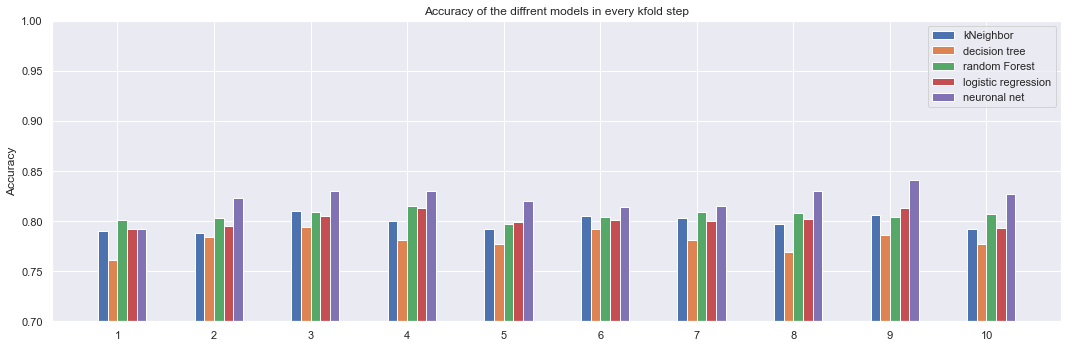

In [35]:
# print accuracy of each k-fold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_1, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_1, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_1, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_1, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_1, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accuracy of the diffrent models in every k-fold step')
ax.legend()

plt.tight_layout()

plt.show()

In [36]:
# calculate average accuracy
avg_kNeighbor_1 = sum(accuracy_kNeighbor_1)/len(accuracy_kNeighbor_1)
avg_decisionTree_1 = sum(accuracy_decisionTree_1)/len(accuracy_decisionTree_1)
avg_randomForest_1 = sum(accuracy_randomForest_1)/len(accuracy_randomForest_1)
avg_logisticRegression_1 = sum(accuracy_logisticRegression_1)/len(accuracy_logisticRegression_1)
avg_neuronalNet_1 = sum(accuracy_neuronalNet_1)/len(accuracy_neuronalNet_1)

In [37]:
# print average accuracy
print(f'KNeighbor: {avg_kNeighbor_1}')
print(f'Decision Tree: {avg_decisionTree_1}')
print(f'Random Forest: {avg_randomForest_1}')
print(f'Logistic Regression: {avg_logisticRegression_1}')
print(f'Neuronal Net: {avg_neuronalNet_1}')

KNeighbor: 0.7984005275965178
Decision Tree: 0.7803509499093839
Random Forest: 0.8059988997027039
Logistic Regression: 0.8017847786774892
Neuronal Net: 0.8221906685715581


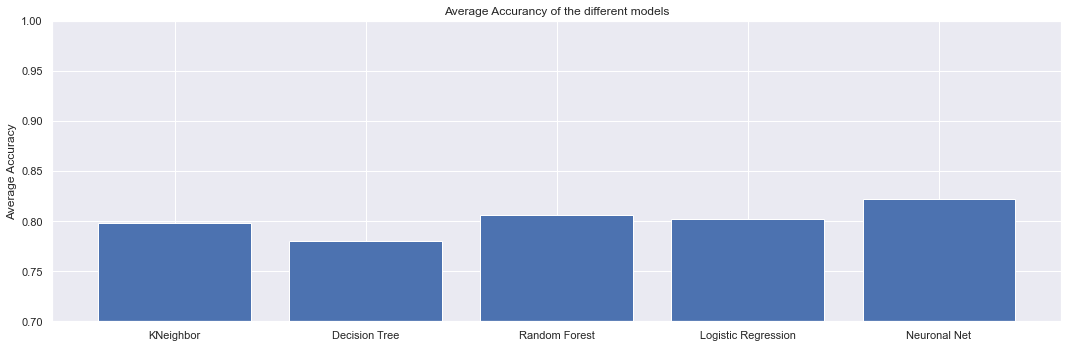

In [38]:
# print average accuracy for each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeighbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_1 = [avg_kNeighbor_1, avg_decisionTree_1, avg_randomForest_1, avg_logisticRegression_1, avg_neuronalNet_1] 

ax.bar(models, avg_accuracies_1)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_title('Average Accuracy of the different models')

plt.tight_layout()
plt.show()

## aproach 2

In [39]:
# define arrays to save the accuracy of every step of k-fold cross validation
accuracy_kNeighbor_2 = []
accuracy_decisionTree_2 = []
accuracy_randomForest_2 = []
accuracy_logisticRegression_2 = []
accuracy_neuronalNet_2 = []

In [40]:
# convert the DataFrames to a NumPy array
X = X.to_numpy()
Y = Y.to_numpy()

In [41]:
# perform k-fold cross validation
for train_index, test_index in kf.split(X):
    
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
    # k-Nearest Neighbors
        kNeighbor = KNeighborsClassifier(n_neighbors=5)
        # train random forest only on training data
        kNeighbor = kNeighbor.fit(X_train, Y_train)
        # test random forest with test data
        kNeighbor_pred = kNeighbor.predict(X_test)
        kNeighbor_accuracy = accuracy_score(Y_test, kNeighbor_pred)
        print(f'K Nearest Neighbor: {kNeighbor_accuracy}')
        accuracy_kNeighbor_2.append(kNeighbor_accuracy)
        
    # Decision Tree
        decisionTree = DecisionTreeClassifier(random_state=0, criterion = 'entropy')
        # train decision tree only on training data
        decisionTree = decisionTree.fit(X_train, Y_train)
        # test decision tree with test data
        decisionTree_pred = decisionTree.predict(X_test)
        decisionTree_accuracy = accuracy_score(Y_test, decisionTree_pred)
        print(f'Decision Tree: {decisionTree_accuracy}')
        accuracy_decisionTree_2.append(decisionTree_accuracy)
        
    # Random Forest
        randomForest = RandomForestClassifier(max_depth=2, random_state=0)
        # train random forest only on training data
        randomForest = randomForest.fit(X_train, Y_train)
        # test random forest with test data
        randomForest_pred = randomForest.predict(X_test)
        randomForest_accuracy = accuracy_score(Y_test, randomForest_pred)
        print(f'Random Forest: {randomForest_accuracy}')
        accuracy_randomForest_2.append(randomForest_accuracy)
        
    # Logistic Regression
        logisticRegression = LogisticRegression(random_state=0, max_iter=500)
        # train logistic regression only on training data
        logisticRegression = logisticRegression.fit(X_train, Y_train)
        # test logistic regression with test data
        logisticRegression_pred = logisticRegression.predict(X_test)
        logisticRegression_accuracy = accuracy_score(Y_test, logisticRegression_pred)
        print(f'Logistic Regression: {logisticRegression_accuracy}')
        accuracy_logisticRegression_2.append(logisticRegression_accuracy)
        
    #Neuronal Net
        neuronalNet = MLPClassifier(random_state=1, max_iter=500).fit(X_train, Y_train)
        neuronalNet_pred = neuronalNet.predict(X_test)
        neuronalNet_accuracy = accuracy_score(Y_test, neuronalNet_pred)
        print(f'Neuronal Net: {neuronalNet_accuracy}')
        accuracy_neuronalNet_2.append(neuronalNet_accuracy)
        print('\n')

K Nearest Neighbor: 0.8054701905347265
Decision Tree: 0.7818070067609096
Random Forest: 0.8103872157344807
Logistic Regression: 0.8057775046097111
Neuronales Net: 0.8211432083589428


K Nearest Neighbor: 0.8070067609096496
Decision Tree: 0.7845728334357713
Random Forest: 0.8073140749846343
Logistic Regression: 0.813460356484327
Neuronales Net: 0.8205285802089736


K Nearest Neighbor: 0.803318992009834
Decision Tree: 0.7793484941610326
Random Forest: 0.7947141979102643
Logistic Regression: 0.8070067609096496
Neuronales Net: 0.8239090350338045


K Nearest Neighbor: 0.809157959434542
Decision Tree: 0.7750460971112477
Random Forest: 0.7907191149354641
Logistic Regression: 0.8051628764597418
Neuronales Net: 0.8334357713583282


K Nearest Neighbor: 0.7980946527350953
Decision Tree: 0.7858020897357099
Random Forest: 0.8017824216349109
Logistic Regression: 0.8030116779348494
Neuronales Net: 0.8279041180086048


K Nearest Neighbor: 0.8156115550092194
Decision Tree: 0.8017824216349109
Random For

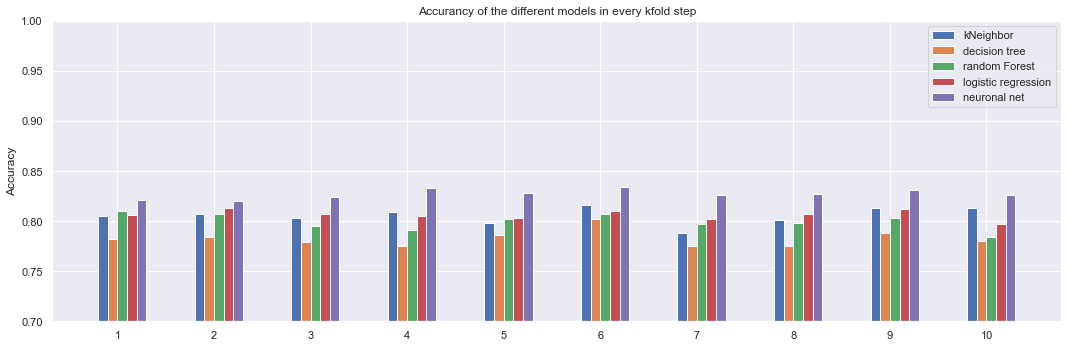

In [42]:
# print accuracy of each k-fold step
plt.figure(figsize=(15,5))
ax = plt.subplot()
width = 0.1

X_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
_X = np.arange(len(X_label))

ax.bar(_X, accuracy_kNeighbor_2, width, label='kNeighbor')
ax.bar(_X + width, accuracy_decisionTree_2, width, label='decision tree')
ax.bar(_X + (2*width), accuracy_randomForest_2, width, label='random Forest')
ax.bar(_X + (3*width), accuracy_logisticRegression_2, width, label='logistic regression')
ax.bar(_X + (4*width), accuracy_neuronalNet_2, width, label='neuronal net')

ax.set_ylabel('Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accuracy of the different models in every k-fold step')
ax.legend()

plt.tight_layout()

plt.show()

In [43]:
# calculate average accuracy
avg_kNeighbor_2 = sum(accuracy_kNeighbor_2)/len(accuracy_kNeighbor_2)
avg_decisionTree_2 = sum(accuracy_decisionTree_2)/len(accuracy_decisionTree_2)
avg_randomForest_2 = sum(accuracy_randomForest_2)/len(accuracy_randomForest_2)
avg_logisticRegression_2 = sum(accuracy_logisticRegression_2)/len(accuracy_logisticRegression_2)
avg_neuronalNet_2 = sum(accuracy_neuronalNet_2)/len(accuracy_neuronalNet_2)

In [44]:
# print average accuracy
print(f'KNeighbor: {avg_kNeighbor_2}')
print(f'Decision Tree: {avg_decisionTree_2}')
print(f'Random Forest: {avg_randomForest_2}')
print(f'Logistic Regression: {avg_logisticRegression_2}')
print(f'Neuronal Net: {avg_neuronalNet_2}')

KNeighbor: 0.8053603774757772
Decision Tree: 0.7827395108406386
Random Forest: 0.7995816352963205
Logistic Regression: 0.8063434707615172
Neuronal Net: 0.8271507214464793


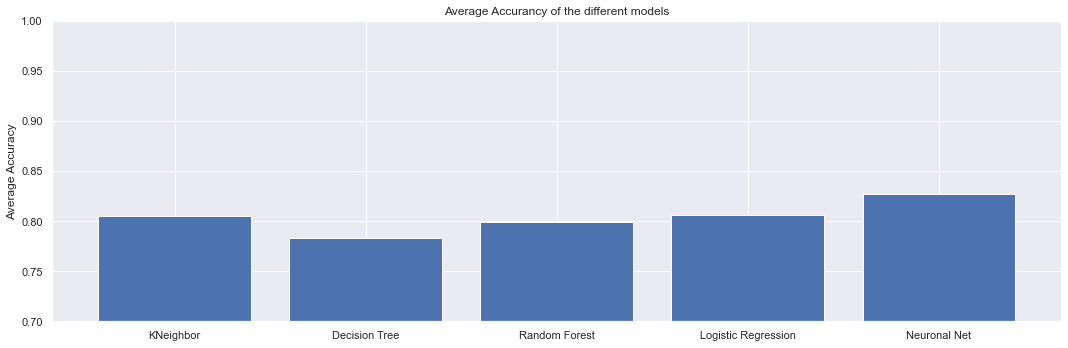

In [45]:
# print average accuracy of each model
plt.figure(figsize=(15,5))
ax = plt.subplot()
models = ['KNeighbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
avg_accuracies_2 = [avg_kNeighbor_2, avg_decisionTree_2, avg_randomForest_2, avg_logisticRegression_2, avg_neuronalNet_2] 

ax.bar(models, avg_accuracies_2)

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_title('Average Accuracy of the different models')

plt.tight_layout()
plt.show()

# evaluation

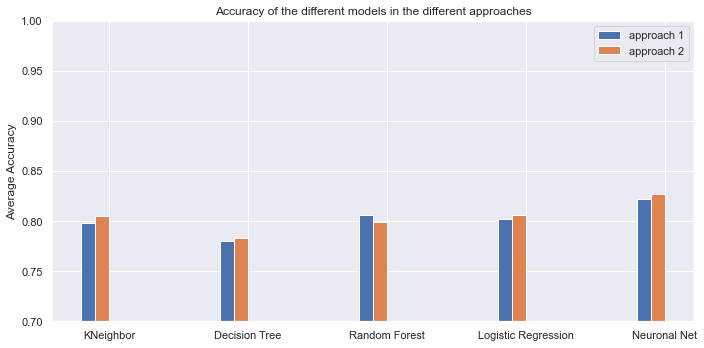

In [46]:
# interpret  model results and provide recommmendations
# print average accuracy of each approach
plt.figure(figsize=(10,5))
ax = plt.subplot()vpn
width = 0.1

X_label = ['KNeighbor', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'Neuronal Net']
_X = np.arange(len(X_label))

ax.bar(_X, avg_accuracies_1, width, label='approach 1')
ax.bar(_X + width, avg_accuracies_2, width, label='approach 2')

ax.set_ylabel('Average Accuracy')
ax.set_ylim(0.7,1)
ax.set_xticks(_X + width + width/2)
ax.set_xticklabels(X_label)
ax.set_title('Accuracy of the different models in the different approaches')
ax.legend()

plt.tight_layout()

plt.show()